# SM2 Temperatures — Adapted to the Public Dataset

This notebook is a **clean adaptation** of the original analysis to work **directly with the public SM2 dataset**.

### Key changes
- Loads **`sm2_public_dataset.parquet`** (or `csv.gz`) instead of raw CSV folders from Drive.
- Uses the dataset's **normalized `location`** values (the **`to`** codes in your mapping).
- Provides a **compatibility helper** to translate any legacy raw `from` codes to the normalized `to` codes.
- Replaces previous use of `temp_intake` as "outdoor" with **`temp_ambient`** (true ambient from Atrea).

**Time zone:** All aggregates are computed in **Europe/Prague** (raw timestamps are UTC).


In [1]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.rcParams['figure.figsize'] = (12, 6)
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)


## Load the public dataset (Parquet preferred)

You can place the files next to this notebook or let it download them from Google Drive using their IDs.

In [2]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Place it next to this notebook or enable internet to download.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
df['local_time'] = df['time'].dt.tz_convert('Europe/Prague')
df['local_day'] = df['local_time'].dt.floor('D')
df['year'] = df['local_time'].dt.year
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 57.5MB/s]


Shape: (651332, 9)


,time,location,source,measurement,data_key,data_value,local_time,local_day,year
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023


## Optional: load mapping (legacy `from` → normalized `to`)

The **public dataset already uses `to`** codes in column `location`. You only need this mapping if you still refer to **old raw** codes somewhere (to translate them).

In [3]:
map_path = Path('location_map.csv')
map_df = None
raw2norm = {}
if map_path.exists():
    map_df = pd.read_csv(map_path)
    if {'from','to'}.issubset(map_df.columns):
        raw2norm = dict(map_df[['from','to']].dropna().values)
        print('Loaded mapping rows:', len(raw2norm))
    else:
        print('Mapping file found but missing required columns: from, to')
else:
    print('No mapping file present — proceeding without it (not needed for the public dataset).')

def map_raw_locations(raw_list):
    """Translate a list of legacy raw location strings to normalized `to` codes.
    Unknown entries are left unchanged so you see what didn't map.
    """
    if not raw2norm:
        return raw_list
    return [raw2norm.get(x, x) for x in raw_list]


No mapping file present — proceeding without it (not needed for the public dataset).


## Convenience helpers
- `select_data(...)` filters the public dataset.
- Regex helpers to parse normalized locations.

In [4]:
def select_data(source=None, keys=None, locations=None, start=None, end=None):
    q = df.copy()
    if source is not None:
        q = q[q['source'].isin([source] if isinstance(source, str) else list(source))]
    if keys is not None:
        q = q[q['data_key'].isin([keys] if isinstance(keys, str) else list(keys))]
    if locations is not None:
        q = q[q['location'].isin([locations] if isinstance(locations, str) else list(locations))]
    if start is not None:
        q = q[q['local_time'] >= pd.Timestamp(start, tz='Europe/Prague')]
    if end is not None:
        q = q[q['local_time'] <= pd.Timestamp(end, tz='Europe/Prague')]
    return q

def parse_norm_location(loc: str):
    # Atrea sections: sm2_01..sm2_09
    if isinstance(loc, str) and loc.startswith('sm2_'):
        return {'kind':'Atrea', 'section': loc}
    # ThermoPro corridors/garages: e.g., 5NP-S5, 1PP-S1
    m = re.match(r'^(?P<floor>\d(?:NP|PP))-S(?P<section>\d+)$', str(loc))
    if m:
        return {'kind':'ThermoPro', 'floor': m.group('floor'), 'section': f"S{m.group('section')}"}
    return {'kind':'unknown'}


## Example A — Hourly averages for selected **corridor** locations (ThermoPro)

This mirrors the original plot but uses **normalized locations**. If you still have old `SM2_*` codes, pass them through `map_raw_locations([...])` first.

/tmp/ipython-input-3912112033.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tp['hourly'] = tp['local_time'].dt.floor('H')


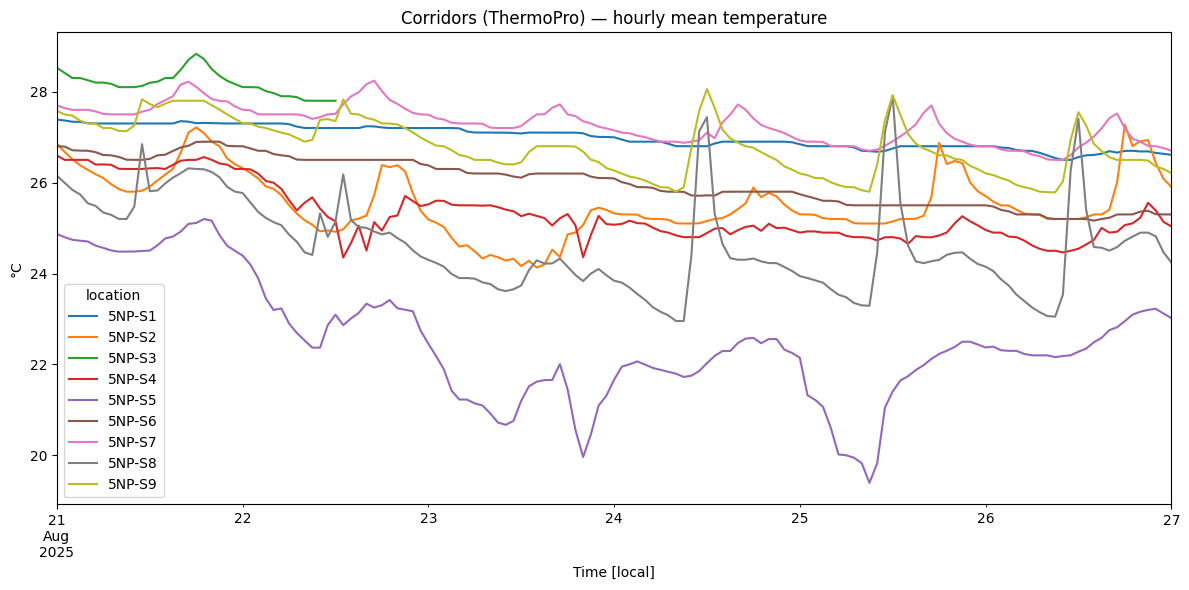

Saved: outputs/corridors_hourly_means.png


In [12]:
# Choose a window similar to the original notebook
START = '2025-08-21 00:00:00'
END   = '2025-08-27 00:00:00'

# Example legacy raw list (uncomment & edit if you want to translate legacy codes):
# legacy_raw = ['SM2_03_L5/L6_01','SM2_05_L5/L6_01','SM2_01_L5/L6_01','SM2_02_L5/L6_01']
# norm_locs = map_raw_locations(legacy_raw)

# Or simply use normalized directly (5NP corridors examples):
norm_locs = ['5NP-S1','5NP-S2','5NP-S3','5NP-S4','5NP-S5','5NP-S6','5NP-S7','5NP-S8','5NP-S9']

tp = select_data(source='ThermoPro', keys='temp_indoor', locations=norm_locs, start=START, end=END).copy()
if tp.empty:
    print('No ThermoPro rows found for the selection.')
else:
    tp['hourly'] = tp['local_time'].dt.floor('H')
    hourly = tp.groupby(['location','hourly'])['data_value'].mean().unstack(0)
    fig = plt.figure(); ax = plt.gca()
    hourly.plot(ax=ax)
    ax.set_title('Corridors (ThermoPro) — hourly mean temperature')
    ax.set_xlabel('Time [local]'); ax.set_ylabel('°C')
    plt.tight_layout(); plt.savefig(OUT_DIR / 'corridors_hourly_means.png', dpi=150); plt.show()
    print('Saved:', OUT_DIR / 'corridors_hourly_means.png')


## Example B — Atrea sections + **ambient** (as outdoor reference)

In the original notebook, `temp_intake` was used as a proxy for outdoor. Here we switch to **`temp_ambient`**, which is the dedicated ambient sensor.

/tmp/ipython-input-54374054.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  atr_in['hourly'] = atr_in['local_time'].dt.floor('H')
/tmp/ipython-input-54374054.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  atr_amb['hourly'] = atr_amb['local_time'].dt.floor('H')


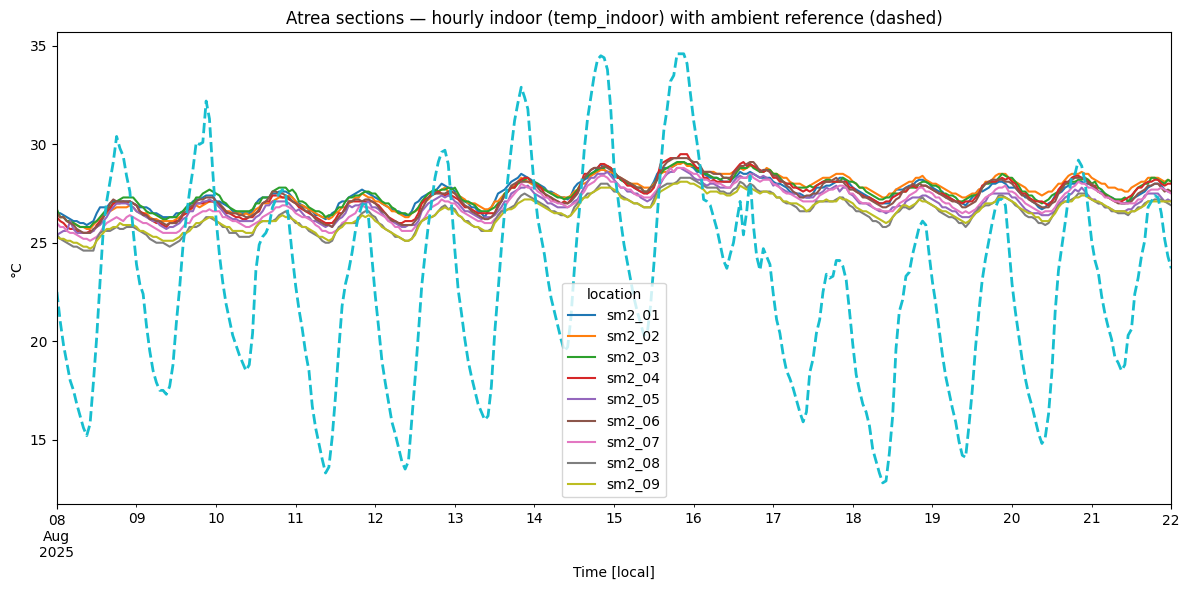

Saved: outputs/atrea_hourly_with_ambient.png


In [9]:
START = '2025-08-08 00:00:00'
END   = '2025-08-22 00:00:00'

sections = [f'sm2_{i:02d}' for i in range(1,10)]

# Indoor exhaust (proxy for indoor)
atr_in = select_data(source='Atrea', keys='temp_indoor', locations=sections, start=START, end=END)
# Ambient reference
atr_amb = select_data(source='Atrea', keys='temp_ambient', locations=sections, start=START, end=END)

if atr_in.empty or atr_amb.empty:
    print('Insufficient Atrea data in the selected window.')
else:
    # hourly indoor per section
    atr_in['hourly'] = atr_in['local_time'].dt.floor('H')
    in_hourly = atr_in.groupby(['location','hourly'])['data_value'].mean().unstack(0)

    # hourly ambient averaged across sections (one line)
    atr_amb['hourly'] = atr_amb['local_time'].dt.floor('H')
    amb_hourly = atr_amb.groupby('hourly')['data_value'].mean()

    fig = plt.figure(); ax = plt.gca()
    in_hourly.plot(ax=ax)
    amb_hourly.plot(ax=ax, linewidth=2, linestyle='--')
    ax.set_title('Atrea sections — hourly indoor (temp_indoor) with ambient reference (dashed)')
    ax.set_xlabel('Time [local]'); ax.set_ylabel('°C')
    plt.tight_layout(); plt.savefig(OUT_DIR / 'atrea_hourly_with_ambient.png', dpi=150); plt.show()
    print('Saved:', OUT_DIR / 'atrea_hourly_with_ambient.png')


## Example C — Quick daily maxima comparison

Reproduces daily-max style plots with the normalized locations only.

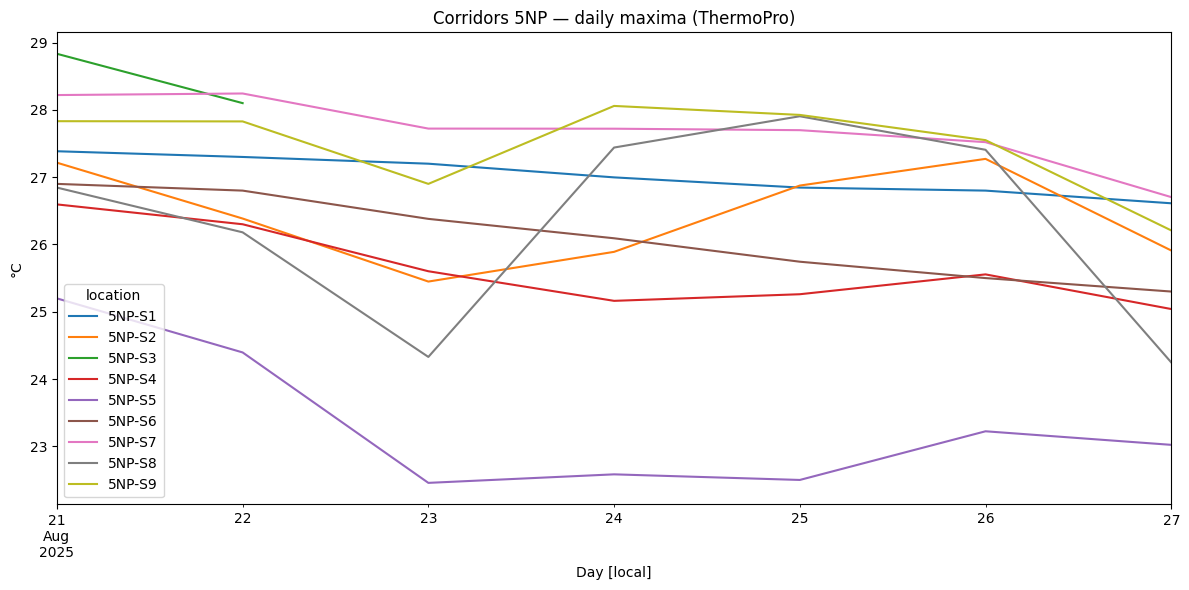

Saved: outputs/corridors_daily_maxima.png


In [11]:
START = '2025-08-21 00:00:00'
END   = '2025-08-27 00:00:00'

tp = select_data(source='ThermoPro', keys='temp_indoor', locations=['5NP-S1','5NP-S2','5NP-S3','5NP-S4','5NP-S5','5NP-S6','5NP-S7','5NP-S8','5NP-S9'], start=START, end=END)
if tp.empty:
    print('No ThermoPro data for the selection.')
else:
    tp['day'] = tp['local_time'].dt.floor('D')
    dmax = tp.groupby(['location','day'])['data_value'].max().unstack(0)
    fig = plt.figure(); ax = plt.gca()
    dmax.plot(ax=ax)
    ax.set_title('Corridors 5NP — daily maxima (ThermoPro)')
    ax.set_xlabel('Day [local]'); ax.set_ylabel('°C')
    plt.tight_layout(); plt.savefig(OUT_DIR / 'corridors_daily_maxima.png', dpi=150); plt.show()
    print('Saved:', OUT_DIR / 'corridors_daily_maxima.png')


### Notes
- If you copy portions of your **original notebook**, the **only changes** you typically need:
  1) Replace `combined` with `df` from this notebook (public dataset).
  2) Replace any legacy raw `location` filters with **normalized codes** (or call `map_raw_locations([...])`).
  3) Prefer **`temp_ambient`** for outdoors instead of `temp_intake`.
- All figures follow the rule: **Matplotlib, one chart per figure, no explicit colors**.
